In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from lmfit.models import GaussianModel

import image_analysis as ia # module with most of the code
import drop_detection_tools as ddt

from importlib import reload

reload(plt)
%matplotlib notebook

## Extract frames from video

This needs to be done only once for every video

In [2]:
path = './T-data/18-11/'
video_name = 'B-ol10-aq30-spf1.wmv'

ia.extract_frames(path, video_name)

Frames already extracted :)


## Get arrays from video

In [3]:
folder = './T-data/18-11/B-ol10-aq30-spf1'

spf = 1                    # seconds per frame in the video

color = 1 # green

arrays, mean_array = ia.get_arrays(folder,color)

print(arrays.shape)


# spannometric estimation velocity of the droplets

#********************************************************
radius  = 0.3  # capillary radius [mm]
flux_ol = 10   # oil flux   [uL/min] = [mm3/min]
flux_aq = 30   # water flux [uL/min] = [mm3/min]
#********************************************************

A  = np.pi*0.25*radius**2       # capillary area [mm2]
v  = (flux_ol + flux_aq)/A/60   # drops speed [mm/s]

print('v  = ', v,'\t[mm/s]')

Image.fromarray(mean_array).show()

(299, 960, 1280)
v  =  9.431404035075278 	[mm/s]


## Subtract the mean

In [4]:
arrays_sub = ia.subtract_mean(arrays,mean_array, negative=True)

m = -145.0, M = 154.0
Subtracting the bias will generate some overflow
Rescale arrays to avoid overflow? [y/n] y


In [5]:
# see an example

idx = 9

Image.fromarray(arrays[idx]).show()
Image.fromarray(arrays_sub[idx]).show()

In [6]:
# see the corresponding negative image

neg = 255 - arrays_sub[idx]
Image.fromarray(neg).show()

## Rotation and gaussian filter

In [6]:
# test on one image

rotation = 32
filter_size = 3 # y and x sigmas for the filter

img = ia.preprocess(arrays_sub[idx], rotation=rotation, filter_size=filter_size)
img.show()

In [7]:
# apply to all images
imgs = []
for array_sub in tqdm(arrays_sub):
    imgs.append(ia.preprocess(array_sub, rotation=rotation, filter_size=filter_size))

imgs = np.array(imgs,dtype=Image.Image)
# calibration image
calibr_img = ia.preprocess(arrays[idx], rotation=rotation, filter_size=0) # keep the image sharp

calibr_img.show()

100%|██████████| 299/299 [00:14<00:00, 20.16it/s]


## Channel analyzer

### Calibrate

In [8]:
c = ia.Channel_analyzer()

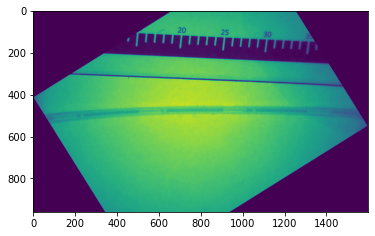

In [21]:
c.calibrate(calibr_img,15)

<IPython.core.display.Javascript object>


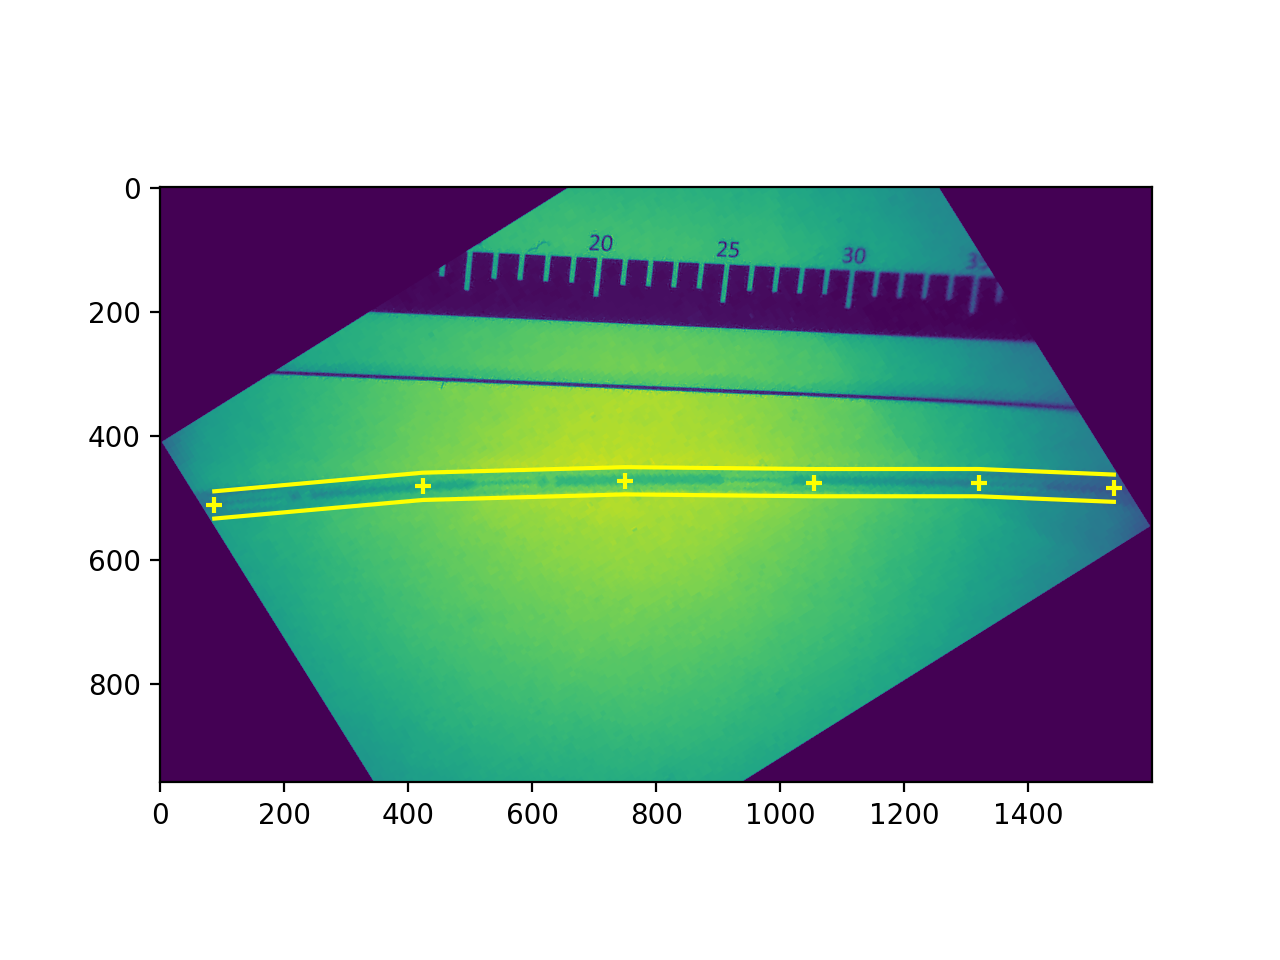

In [11]:
c.find_channel(calibr_img)

### Save calibration

In [ ]:
c.save(name='calibr_B-ol10-aq30',folder='./T-data/18-11/')

### Load from existing calibration

In [9]:
c.load(name='calibr_B-ol10-aq30',folder='./T-data/18-11')

### Try waveform extraction on one image

<IPython.core.display.Javascript object>


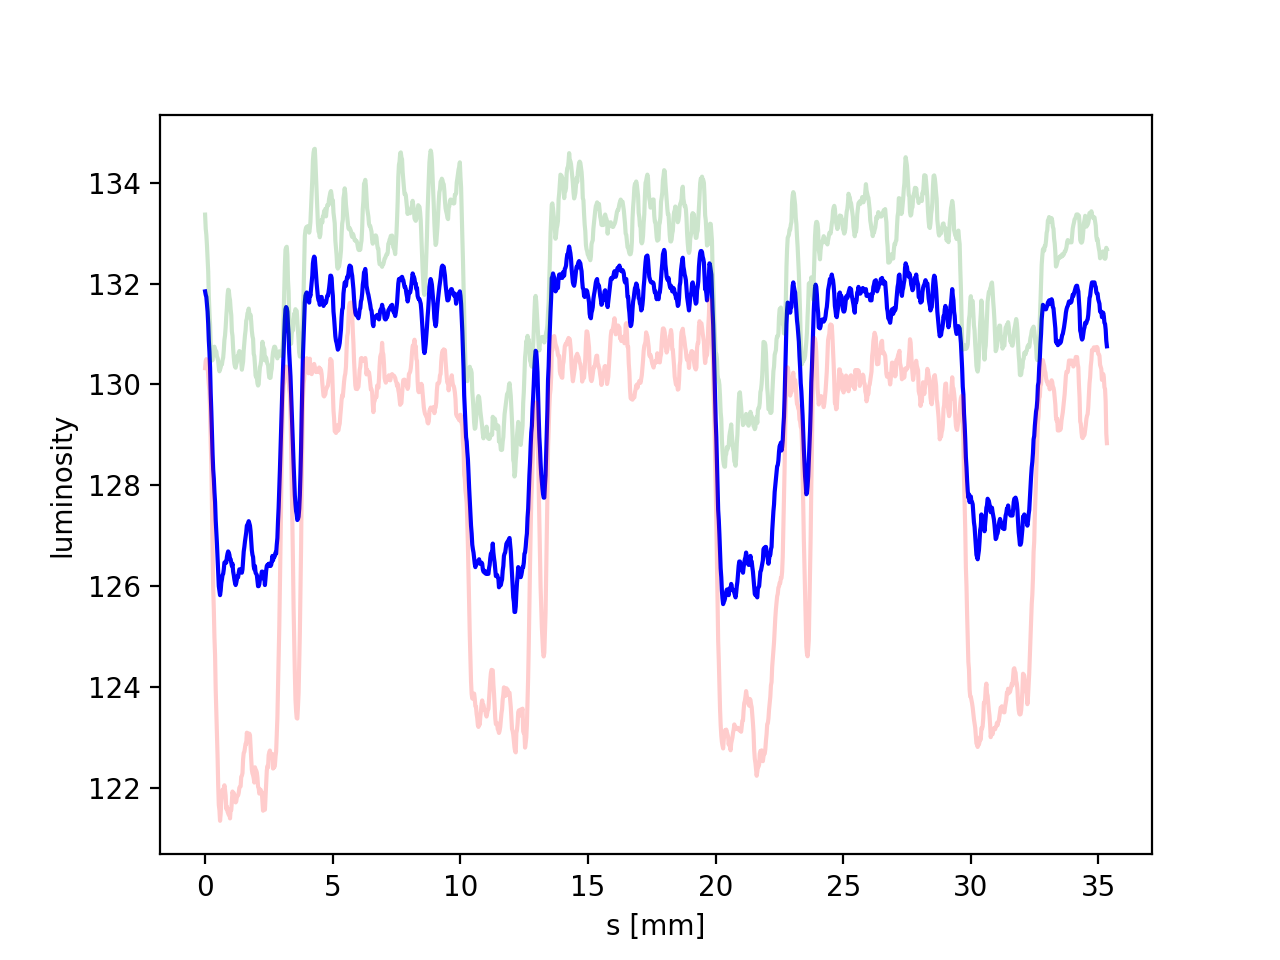

Text(0, 0.5, 'luminosity')

In [10]:
idx = 9

img = imgs[idx]
s, mean, std = c.evaluate(img)

plt.figure()
plt.plot(s,mean, color='blue')
plt.plot(s,mean - std,color='red',alpha=0.2)
plt.plot(s,mean + std,color='green',alpha=0.2)

plt.xlabel('s [mm]')
plt.ylabel('luminosity')

## Extract the waveforms

In [11]:
s     = 0.
means = []
stds  = []

for idx in tqdm(range(len(imgs))):
    s, mean, std = c.evaluate(imgs[idx])
    means.append(mean)
    stds.append(std)

100%|██████████| 299/299 [00:21<00:00, 13.92it/s]


## Threshold searching and drop computing functions

In [26]:
# see drop_detection_tools

## Thresholds searching 

<Figure size 432x288 with 0 Axes>

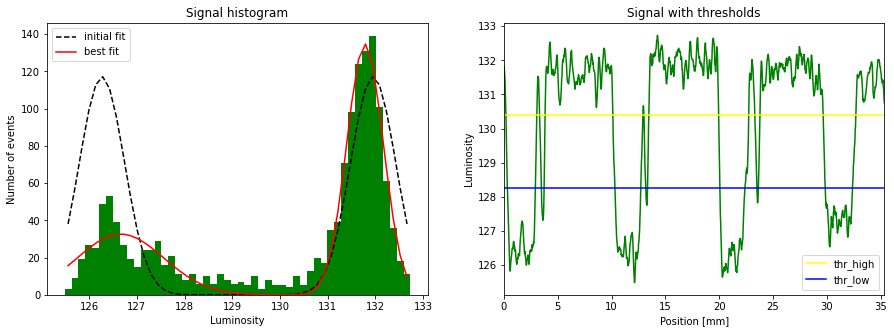

In [12]:
# Luminosity thresholds searching

#**************************************************
idx         = 9     # Frame index (checking plots)
nbins       = 50    # Histo bins number
plot_switch = True  # Plots activation

high_sigmas = 4
low_sigmas = 2

# Not needed
# ymin      = 120   # Plot min. luminosity
# ymax      = 130   # Plot max. luminosity
#**************************************************

%matplotlib inline

# Plot one single signal (checking)
thr_low, thr_high = ddt.thr_searcher(Ydata=means[idx], nbins=nbins, plot_switch=plot_switch, Xdata=s,
                                     high_sigmas=high_sigmas, low_sigmas=low_sigmas)

### Compute thr for every image

Can produce errors

  4%|▎         | 11/299 [00:00<00:17, 16.03it/s]

  5%|▌         | 16/299 [00:00<00:16, 17.65it/s]

 30%|██▉       | 89/299 [00:04<00:09, 21.04it/s]

 37%|███▋      | 112/299 [00:05<00:08, 21.45it/s]

 56%|█████▌    | 167/299 [00:08<00:09, 13.57it/s]

100%|██████████| 299/299 [00:15<00:00, 19.12it/s]


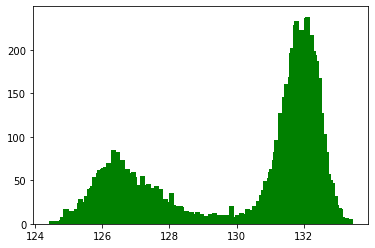

In [15]:
#for all images
thrs_low  = []    # thr_low array
thrs_high = []    # thr_high array

for mean in tqdm(means):
    thr_low, thr_high = ddt.thr_searcher(Xdata=s, Ydata=mean, nbins=nbins, plot_switch=False)
    thrs_low.append(thr_low)
    thrs_high.append(thr_high)

In [29]:
print(f'thrs_low: \t mean = {np.mean(thrs_low)}  \t std = {np.std(thrs_low,ddof=1)}')
print(f'thrs_high:\t mean = {np.mean(thrs_high)} \t std = {np.std(thrs_high,ddof=1)}')

thrs_low: 	 mean = 122.18641036257678  	 std = 0.2538114366186062
thrs_high:	 mean = 123.10704569730733 	 std = 1.6956861158985166


### Compute the thresholds using all data at once

<Figure size 432x288 with 0 Axes>

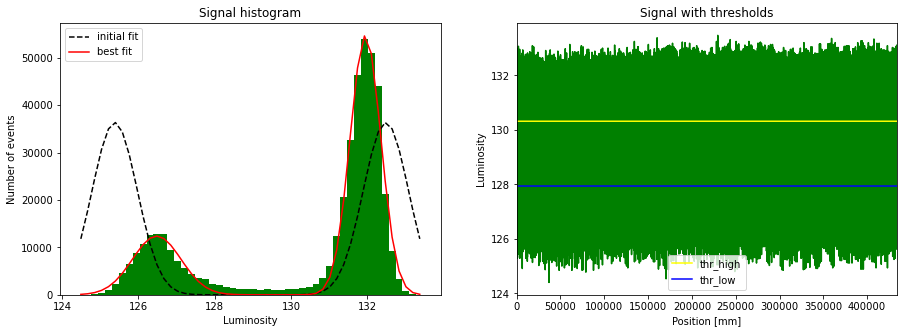

In [13]:
nbins       = 50    # Histo bins number
plot_switch = True  # Plots activation

high_sigmas = 4
low_sigmas = 2

thr_low, thr_high = ddt.thr_searcher(Ydata=np.concatenate(means), nbins=nbins, plot_switch=plot_switch,
                                     high_sigmas=high_sigmas, low_sigmas=low_sigmas)

## Drop detection 

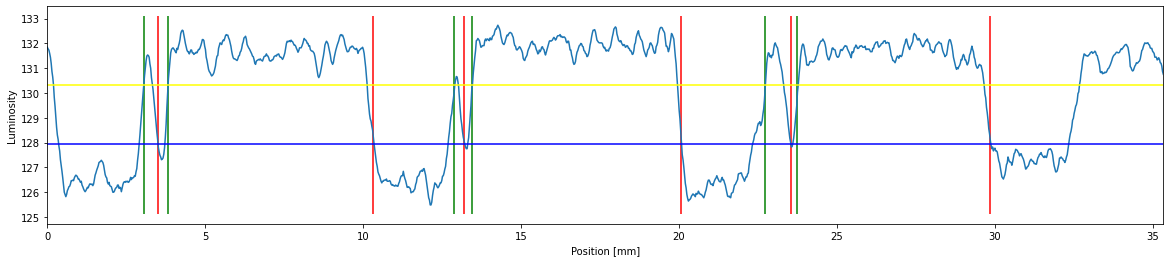

In [14]:
# Detection of the edges of the drops

#**************************************************
idx         = 9   # Frame index (checking plot)
plot_switch = True  # Plots activation
# Not needed
# xrange    = 35    # Plot x max.
# ymin      = 120   # Plot min. luminosity 
# ymax      = 130   # Plot max luminosity 
#**************************************************

# Plot one single signal (checking)
%matplotlib inline
drop_start, drop_end = ddt.drop_det(Xdata=s, Ydata=means[idx],
                                    thr_low=thr_low, thr_high=thr_high, plot_switch=plot_switch)

### Compute starts and ends for every frame

In [36]:
#for all images
drop_starts = []    # drop_start array
drop_ends   = []    # drop_end array

for mean in means[175:]:
    drop_start, drop_end = ddt.drop_det(Xdata=s, Ydata=mean, thr_low=thr_low, thr_high=thr_high, plot_switch=False)
    drop_starts.append(drop_start)
    drop_ends.append(drop_end)

## Velocity computing 

### Simple velocity estimation

100%|██████████| 298/298 [00:00<00:00, 136437.35it/s]


Text(0, 0.5, 'Number of events')

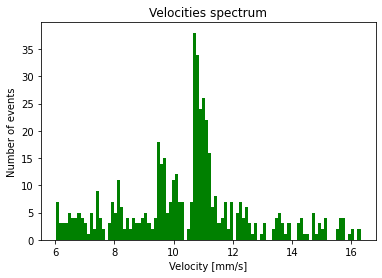

In [40]:
#******************************************************************************
imgs_switch = False        # Images activation

nbins       = 100          # Velocity histogram bins number
thr         = 6.           # Min. velocity acceptable [mm/s] 
vec         = drop_starts  # Velocity computed on 'drop_starts' or 'drop_ends'
#******************************************************************************

diffs = []

# iterate over frames
for idx in tqdm(range(len(vec) - 1)):
    delay_idx = -1
    exit = False
    diffs.append([])
    # iterate over droplets in a frame
    for i,drop in enumerate(vec[idx]):
        diff = 0.
        # look for the same droplet in the next frame
        while(diff < thr):
            delay_idx += 1
            try:
                diff = vec[idx + 1][delay_idx] - drop
            except(IndexError):
                exit = True
                break
        if exit:
            if len(diffs[-1]) == 1:
                if imgs_switch == True:
                    imgs[idx].show()
            break
        diffs[-1].append(diff)
        
velocities = np.concatenate(diffs)/spf
        
# Plot 
plt.figure()
plt.hist(velocities, bins = nbins, color='green')
plt.title('Velocities spectrum')
plt.xlabel('Velocity [mm/s]')
plt.ylabel('Number of events')

Text(0, 0.5, 'velocity [mm/s]')

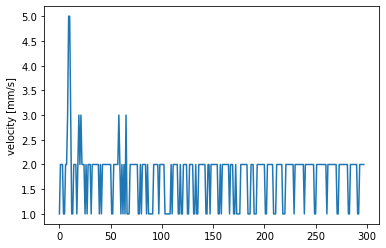

In [41]:
plt.figure()
plt.plot([len(diff) for diff in diffs])

plt.ylabel('velocity [mm/s]')

<Figure size 432x288 with 0 Axes>

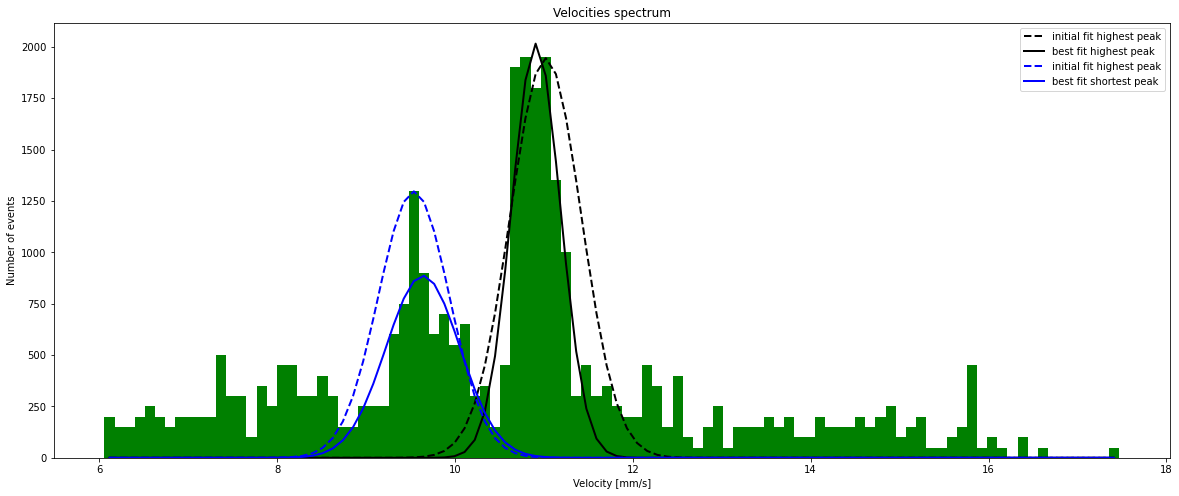

In [386]:
# Velocity fitting

#**************************************************
nbins = 100   # Histo bins number
k     = 2     
#**************************************************
  
# Histogram definition
freq,bins,p = plt.hist(velocities, nbins, color='green') 
x = 0.5 *(bins[:-1] + bins[1:]) 


# Fit highest peak ----------------------------------------------------------

# Max 1 finding
xmax1 = x[np.nonzero(freq==max(freq))]

# Fit
gauss1  = GaussianModel(prefix='g1_')
pars1   = gauss1.make_params(center=xmax1[1], sigma=0.4 , amplitude=max(freq))
result1 = gauss1.fit(freq, pars1, x=x)


# Fit lower peak -------------------------------------------------------------

# Max 2 finding
center1 = result1.best_values.get('g1_center')
sigma1  = result1.best_values.get('g1_sigma')
freq2   = freq 
i       = 0
while( i < len(freq)):
    if (x[i] > center1-k*sigma1) and (x[i] < center1+k*sigma1):
        freq2[i] = 0
    i = i+1
xmax2 = x[np.nonzero(freq2==max(freq2))]
    
# Fit    
gauss2  = GaussianModel(prefix='g2_')
pars2   = gauss2.make_params(center=xmax2[0], sigma=0.4 , amplitude=max(freq))
result2 = gauss2.fit(freq, pars2, x=x)


# Plot ------------------------------------------------------------------------

%matplotlib inline
plt.figure()
plt.figure(figsize=(20,8))
plt.hist(velocities, nbins, color='green')
plt.plot(x, result1.init_fit, 'k--', lw=2, label='initial fit highest peak')
plt.plot(x, result1.best_fit, 'k-', lw=2, label='best fit highest peak')
plt.plot(x, result2.init_fit, 'b--', lw=2, label='initial fit highest peak')
plt.plot(x, result2.best_fit, 'b-', lw=2, label='best fit shortest peak')
#plt.plot(x, freq2, color='yellow', label='exp. data for shortest peak fit')
plt.legend(loc='best')
plt.title("Velocities spectrum")
plt.xlabel("Velocity [mm/s]")
plt.ylabel("Number of events") 
plt.legend()


## Following the droplets along the video

A better alternative to Simple velocity estimation

In [46]:
# DO NOT TRANSFER TO .py file !!!! uses local variables

class Droplet():
    def __init__(self,ID):
        self.ID = ID
        self.frames = [] # frame IDs in which the droplet appears
        self.index_in_frame = [] # index of the droplet in every frame in which it appears
        
        self.starts = []
        self.ends = []
        
        self.sizes = None
        self.velocities = None
        
    @property
    def recurrence(self):
        return len(self.frames) # number of frames in which the droplet is visible
    
    @property
    def size(self):
        self.sizes = np.array(self.ends) - np.array(self.starts)
        return np.mean(self.sizes), np.std(self.sizes)
    
    @property
    def velocity(self):
        if len(self.frames) > 1:
            self.velocities = (np.array(self.starts[:-1]) - np.array(self.starts[1:]))/spf
            return np.mean(self.velocities), np.std(self.velocities)
        else:
            return np.nan, np.nan
        
    def add(self, frame_id, idx_in_frame, velocity_range=None, size_perc_tolerance=None):
        '''
        Tries to add a new frame to the droplet. Returns True if it manages to.
        '''
        start = drop_starts[frame_id][idx_in_frame]
        end = drop_ends[frame_id][idx_in_frame]
        
        if len(self.frames) > 0:
        
            # check if velocity is meaningful
            if velocity_range is not None:
                velocity = (self.starts[-1] - start)/spf
                if velocity < velocity_range[0]:
                    return False
                if velocity > velocity_range[1]:
                    return False

            # check if size is similar to the previous one
            if size_perc_tolerance is not None:
                old_size = self.ends[-1] - self.starts[-1]
                size = end - start
                if np.abs(size - old_size) > old_size*size_perc_tolerance:
                    return False
                
        self.frames.append(frame_id)
        self.index_in_frame.append(idx_in_frame)
        self.starts.append(start)
        self.ends.append(end)
        return True

100%|██████████| 123/123 [00:00<00:00, 12944.08it/s]


<IPython.core.display.Javascript object>


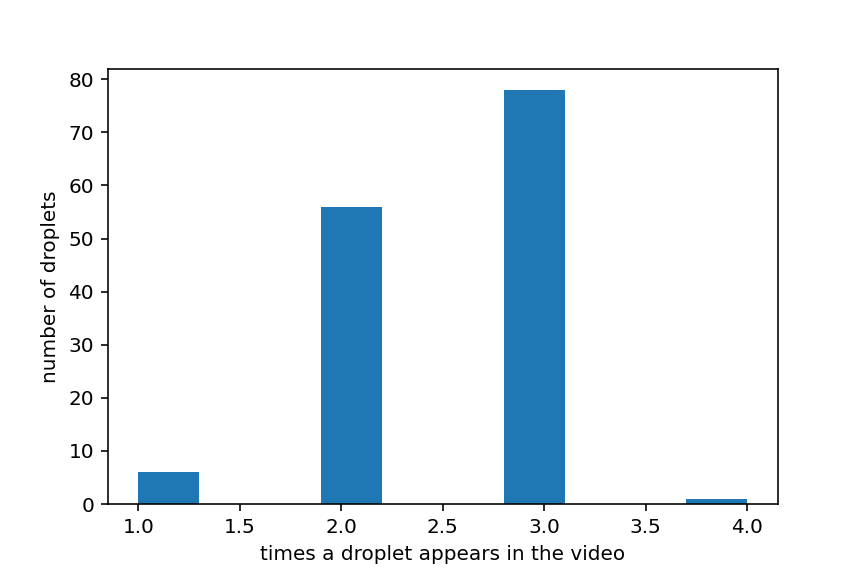

Text(0, 0.5, 'number of droplets')

In [47]:
velocity_range = [6., 12.]
size_perc_tolerance = 1


droplets = []
drop_idx = 0

# create ID mask
ID_mask = []
for drop_start in drop_starts:
    ID_mask.append([-1]*len(drop_start))

# iterate over frame
for idx in tqdm(range(len(drop_starts) - 1)):
    frame_idx = len(drop_starts) - 1 - idx # go reversed
    # iterate over droplets in a frame
    for i,start in enumerate(drop_starts[frame_idx]):
        # detect if droplet is already present
        drop_ID = ID_mask[frame_idx][i]
        if drop_ID == -1: # add new droplet
            ID_mask[frame_idx][i] = drop_ID = drop_idx
            droplets.append(Droplet(drop_idx))
            droplets[drop_idx].add(frame_idx,i)
            drop_idx += 1
        
        # now all droplets in this frame have a valid ID
        # we try to find them in the previous frame (remember we are looking the video in reverse)
        prev_frame_idx = frame_idx - 1
        for prev_i,prev_start in enumerate(drop_starts[prev_frame_idx]):
            if ID_mask[prev_frame_idx][prev_i] != -1: # droplet already assigned
                continue
            if droplets[drop_ID].add(prev_frame_idx,prev_i,
                                     velocity_range=velocity_range, size_perc_tolerance=size_perc_tolerance):
                ID_mask[prev_frame_idx][prev_i] = drop_ID # assign droplet
                break
                
droplets = np.array(droplets,dtype=Droplet)
                
def drops_in_frame(frame_idx):
    drop_ids = ID_mask[frame_idx]
    ddt.drop_det(Xdata=s, Ydata=means[frame_idx],
                                    thr_low=thr_low, thr_high=thr_high, plot_switch=True)
    for drop in droplets[drop_ids]:
        i = drop.frames.index(frame_idx)
        x = 0.5*(drop.starts[i] + drop.ends[i])
        y = 0.5*(thr_high + thr_low)
        plt.scatter(x,y,color='black',marker='^')
        plt.text(x,y + 0.25,drop.ID)
                
    return drop_ids


plt.figure()
plt.hist([d.recurrence for d in droplets])
plt.xlabel('times a droplet appears in the video')
plt.ylabel('number of droplets')

<IPython.core.display.Javascript object>


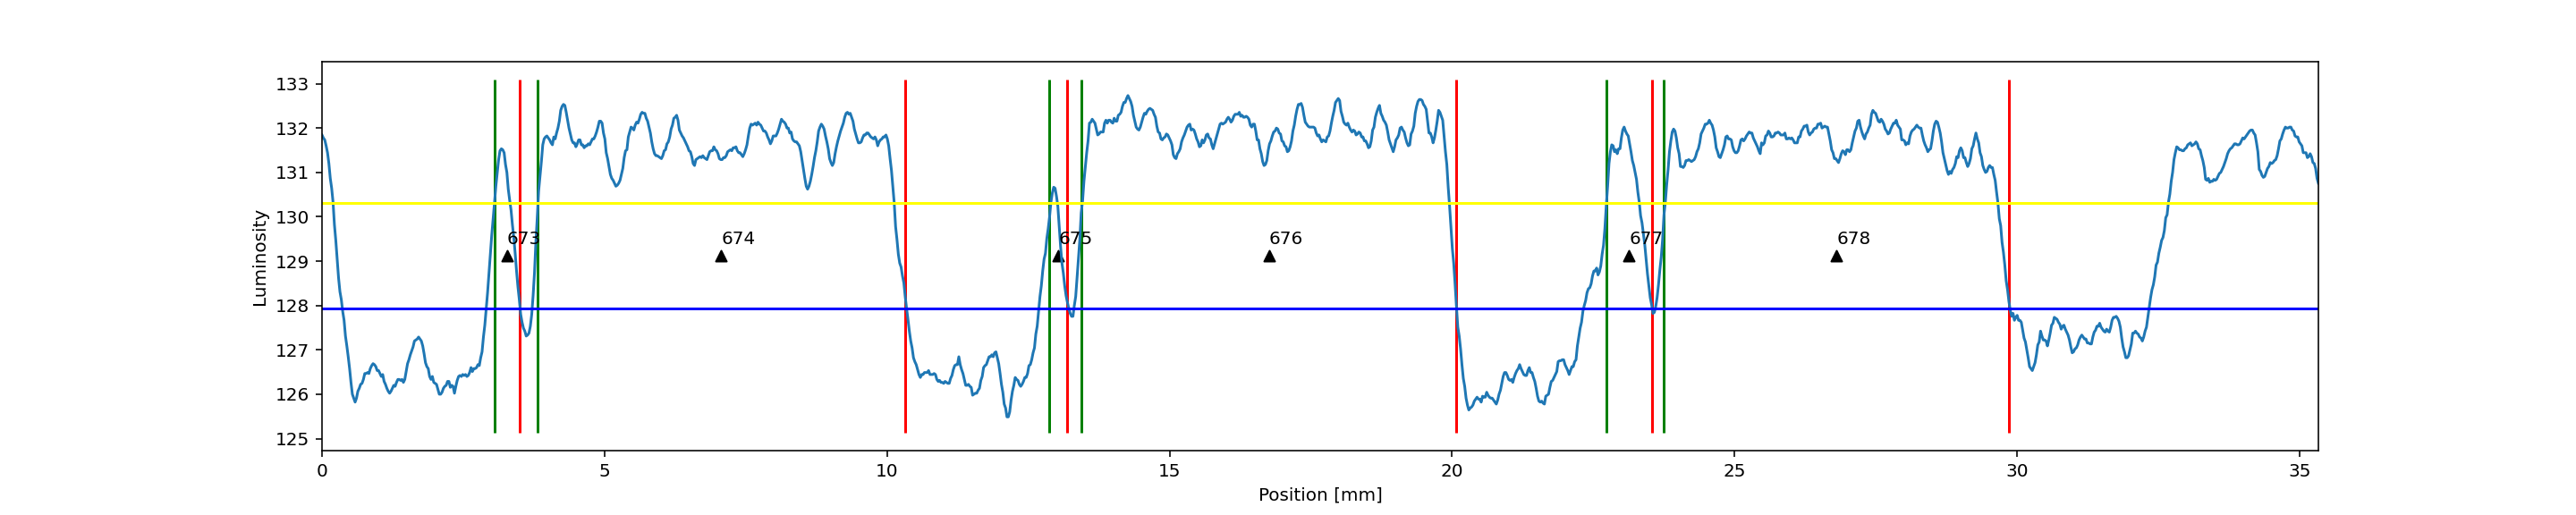

[673, 674, 675, 676, 677, 678]

In [32]:
reload(plt)
%matplotlib notebook
idx = 9
drops_in_frame(idx)

<IPython.core.display.Javascript object>


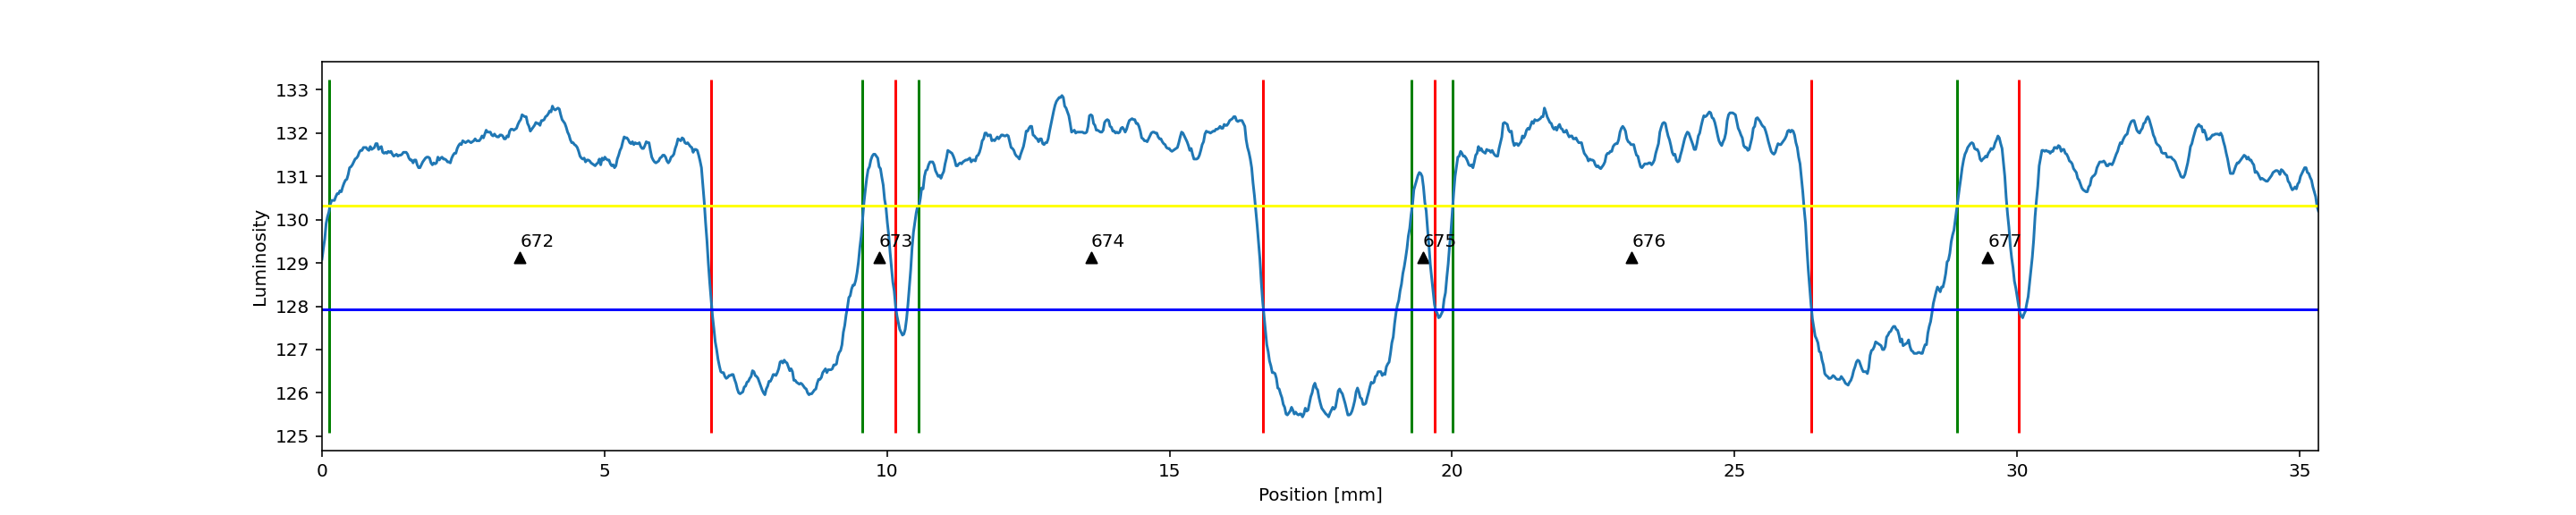

[672, 673, 674, 675, 676, 677]

In [33]:
drops_in_frame(idx + 1)

### Droplet statistics

In [21]:
q = np.sqrt(2*np.pi)

def gaus(x, mu, sigma):
    return np.exp(-(x - mu)**2/(2*sigma**2))/(sigma*q)

# kernel density estimation
def kde_plot(xs, centers, sigmas, min_sigma=0.01,**kwargs):
    ys = np.zeros_like(xs)
    for i,x in tqdm(enumerate(xs)):
        for j,c in enumerate(centers):
            ys[i] += gaus(x,c,max(sigmas[j],min_sigma))
    
    # normalize
    ys /= np.sum(ys)
    
    xlabel = kwargs.pop('xlabel',None)
    plt.figure()
    plt.plot(xs,ys,**kwargs)
    plt.xlabel(xlabel)
    plt.ylabel('probability')
    plt.tight_layout()
    
    return ys

<IPython.core.display.Javascript object>


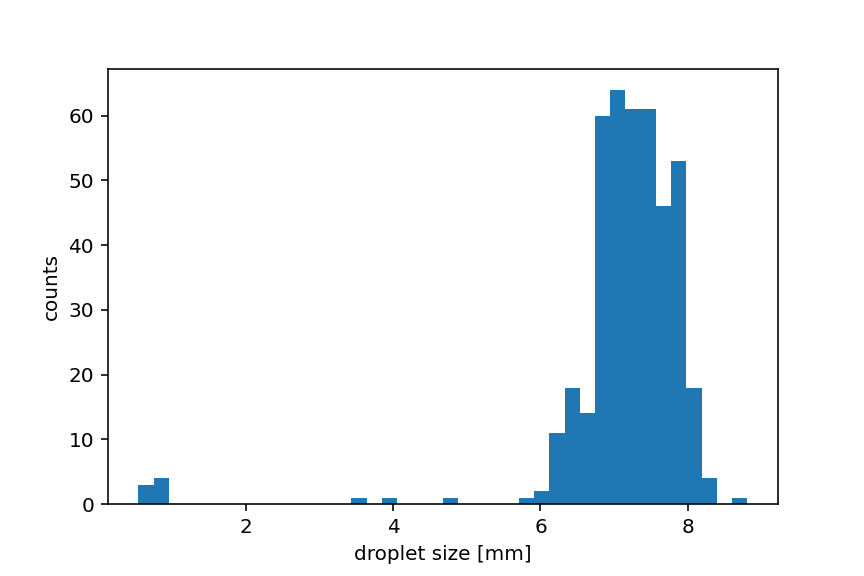

424


In [22]:
# size

min_recurrence = 1

size_means = [d.size[0] for d in droplets if d.recurrence >= min_recurrence]
size_stds = [d.size[1] for d in droplets if d.recurrence >= min_recurrence]


# histogram
plt.figure()
plt.hist(size_means,bins=40)
plt.xlabel('droplet size [mm]')
plt.ylabel('counts')

print(len(size_means))

10000it [00:19, 510.84it/s]


<IPython.core.display.Javascript object>


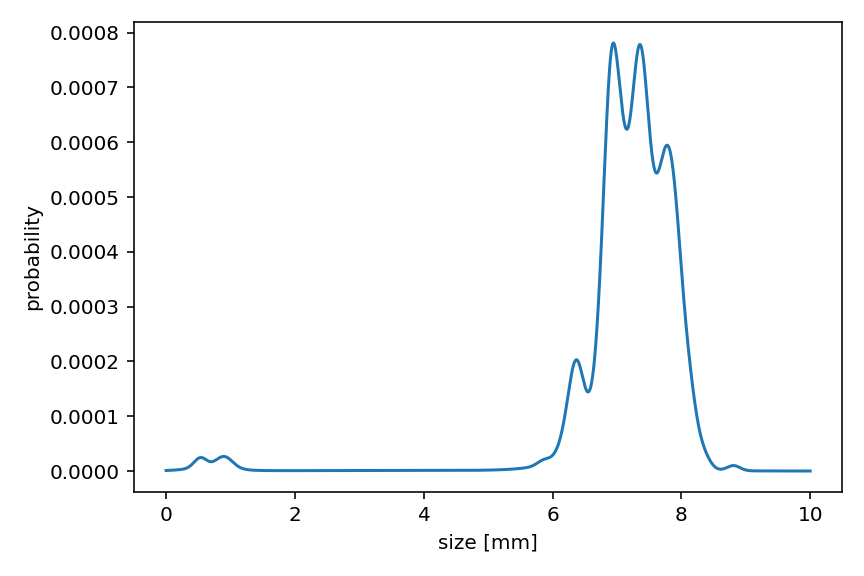

array([1.02628094e-06, 1.03089415e-06, 1.03552917e-06, ...,
       1.07319581e-07, 1.07231798e-07, 1.07144096e-07])

In [23]:
# kde plot

xs = np.linspace(0,10,10000)

kde_plot(xs, size_means, size_stds, min_sigma=0.1, xlabel='size [mm]')

<IPython.core.display.Javascript object>


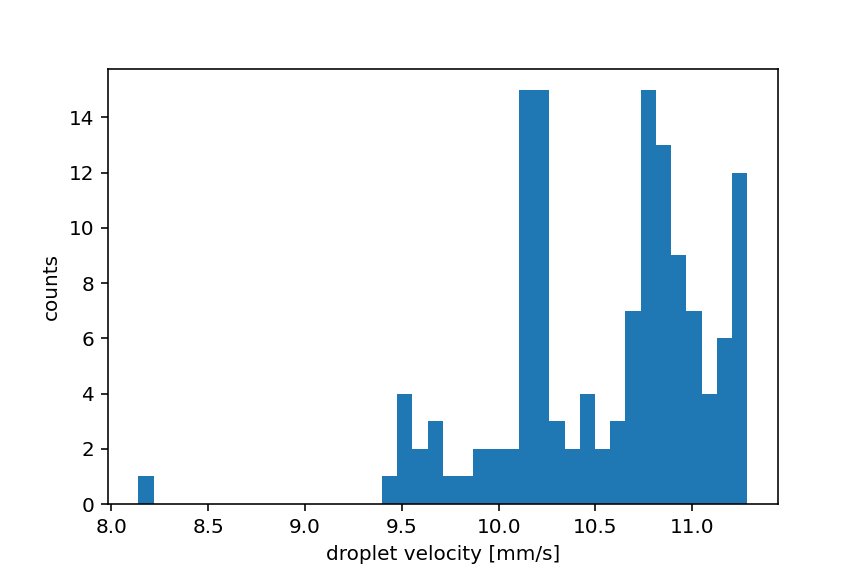

136


In [43]:
# velocity

# at least 2 otherwise cannot compute velocity
min_recurrence = 2

velocity_means = [d.velocity[0] for d in droplets if d.recurrence >= min_recurrence]
velocity_stds = [d.velocity[1] for d in droplets if d.recurrence >= min_recurrence]

# histogram
plt.figure()
plt.hist(velocity_means,bins=40)
plt.xlabel('droplet velocity [mm/s]')
plt.ylabel('counts')

print(len(velocity_means))

10000it [00:09, 1085.43it/s]


<IPython.core.display.Javascript object>


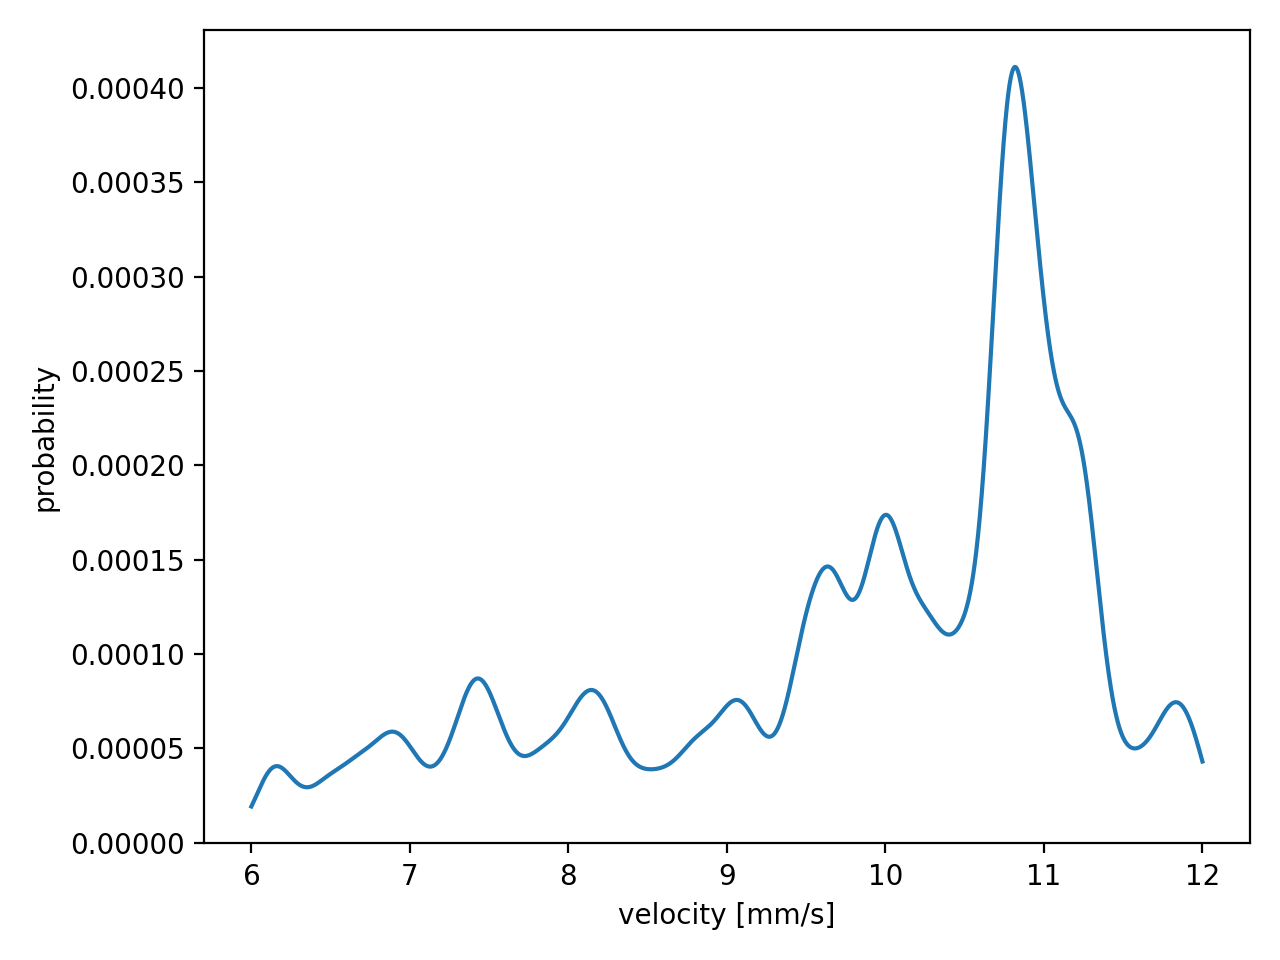

array([1.92251357e-05, 1.93289914e-05, 1.94331427e-05, ...,
       4.34178144e-05, 4.32332270e-05, 4.30486182e-05])

In [97]:
# kde plot

vs = np.linspace(6,12,10000)

kde_plot(vs, velocity_means, velocity_stds, min_sigma=0.1, xlabel='velocity [mm/s]')

<IPython.core.display.Javascript object>


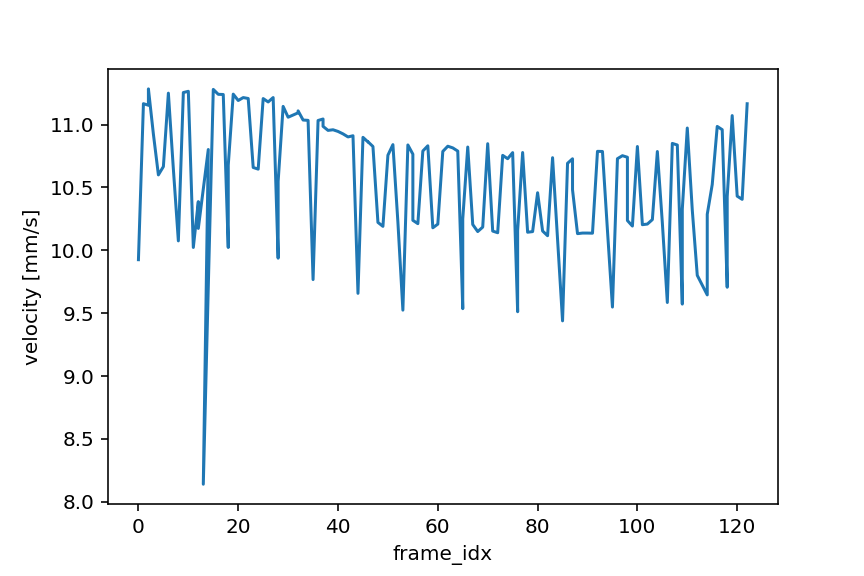

Text(0, 0.5, 'velocity [mm/s]')

In [45]:
# velocity - frame_id correlation

frames_idxs = [d.frames[-1] for d in droplets if d.recurrence >= min_recurrence]

plt.figure()
plt.plot(frames_idxs, velocity_means)
plt.xlabel('frame_idx')
plt.ylabel('velocity [mm/s]')

<IPython.core.display.Javascript object>


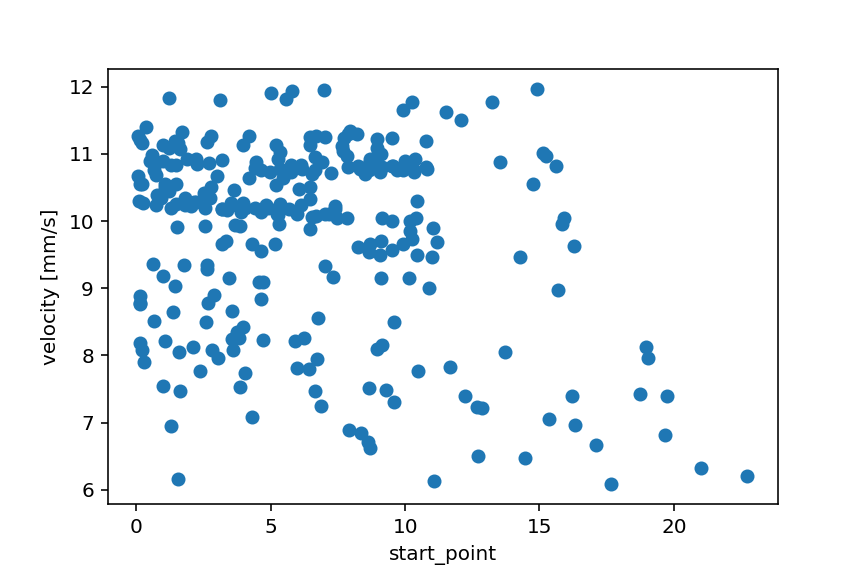

Text(0, 0.5, 'velocity [mm/s]')

In [27]:
# velocity - position correlation

starts= [d.starts[-1] for d in droplets if d.recurrence >= min_recurrence]

plt.figure()
plt.scatter(starts, velocity_means)
plt.xlabel('start_point')
plt.ylabel('velocity [mm/s]')

<IPython.core.display.Javascript object>


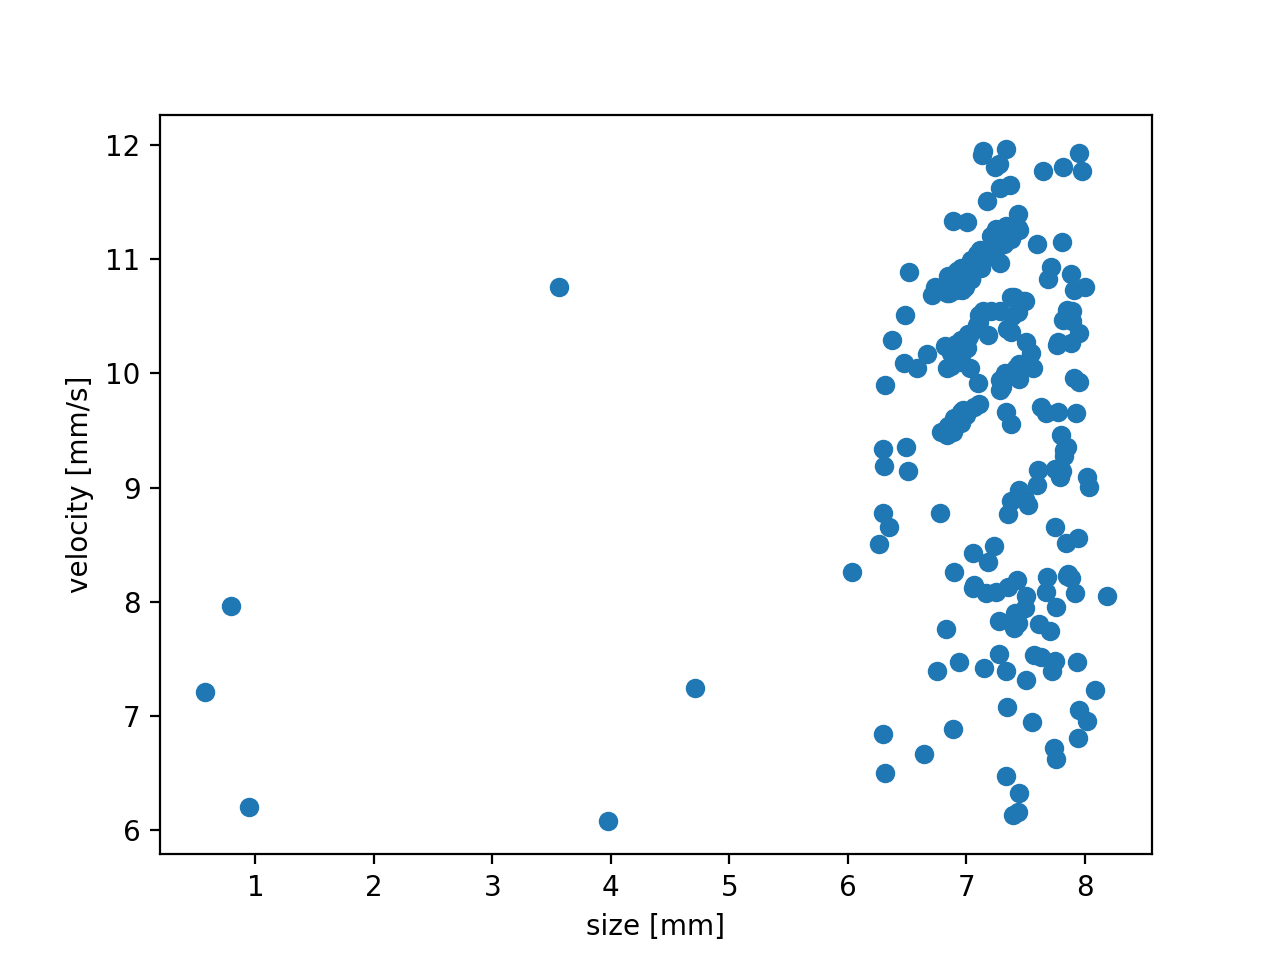

Text(0, 0.5, 'velocity [mm/s]')

In [115]:
# size - velocity correlation

plt.figure()
plt.scatter(size_means, velocity_means)
plt.xlabel('size [mm]')
plt.ylabel('velocity [mm/s]')

<IPython.core.display.Javascript object>


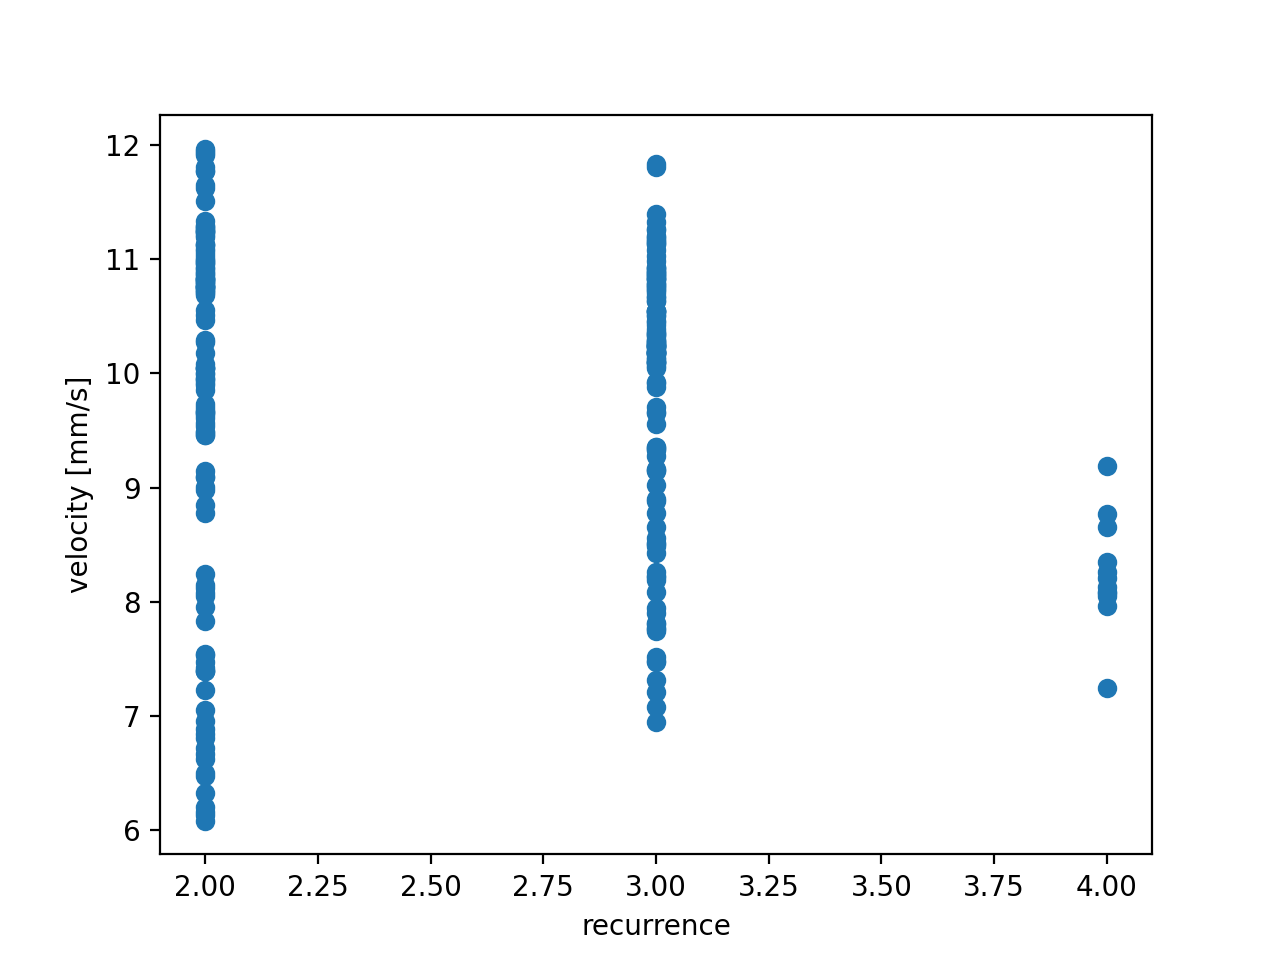

Text(0, 0.5, 'velocity [mm/s]')

In [118]:
# velocity - recurrence correlation

recurrences = [d.recurrence for d in droplets if d.recurrence >= min_recurrence]

plt.figure()
plt.scatter(recurrences, velocity_means)
plt.xlabel('recurrence')
plt.ylabel('velocity [mm/s]')